### Global Validation ###

This notebook combines several validation notebooks: `global_validation_tasmax_v2.ipynb` and `global_validation_dtr_v2.ipynb` along with `check_aiqpd_downscaled_data.ipynb` to create a "master" global validation notebook. It also borrows validation code from the ERA-5 workflow, `validate_era5_hourlyORdaily_files.ipynb`. Parts of this will be incorporated into `dodola` such that minimal global validation is done automatically with every pipeline run. 

### Data Sources ###

Coarse Resolution: 
- CMIP6 
- Bias corrected data 
- ERA-5

Fine Resolution: 
- Bias corrected data 
- Downscaled data 
- ERA-5 (fine resolution)
- ERA-5 (coarse resolution resampled to fine resolution) 

### Types of Validation ### 

Basic: 
- maxes, means, mins  
    - CMIP6, bias corrected and downscaled (data)
    - historical, 2020-2040, 2040-2060, 2060-2080, 2080-2100 
    - 3 x 5 (in case we plot each data source separately in the pipeline) 
- NaN check, ranges, number of timesteps, file metadata attributes, variable names 
- spread between SSPs (this will not be a plot because it involves multiple runs)
- differences between historical and future time periods for bias corrected and downscaled
- differences between bias corrected and downscaled data 

Variable-specific: 
- GMST
- days over 95 (TO-DO)
- max values (precip) 
- negative values (DTR, precip) 
- number of days/gridcells that have wet day frequency correction applied (TO-DO)
- max # of consecutive dry days, highest precip amt over 5-day rolling window (TO-DO) 

In [1]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
from matplotlib import cm

from matplotlib.backends.backend_pdf import PdfPages

from validation import *

### Azure (or GCS) authentication ### 

In [2]:
# ! pip install adlfs

In [3]:
from adlfs import AzureBlobFileSystem
fs_az = AzureBlobFileSystem(
        account_name='dc6',
        account_key='', 
        client_id=os.environ.get("AZURE_CLIENT_ID", None),
        client_secret=os.environ.get("AZURE_CLIENT_SECRET", None),
        tenant_id=os.environ.get("AZURE_TENANT_ID", None))

### Filepaths ###

#### Output data ####

In [4]:
data_dict = {'coarse': {'cmip6': {'historical': 'scratch/biascorrectdownscale-bk6n8/biascorrectdownscale-bk6n8-858077599/out.zarr', 
                                  'ssp370': 'scratch/biascorrectdownscale-bk6n8/biascorrectdownscale-bk6n8-269778292/out.zarr'}, 
                        'bias_corrected': {'historical': 'az://biascorrected-stage/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/tasmax/gr1/v20210920214427.zarr', 
                                                                                      'ssp370': 'az://biascorrected-stage/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/day/tasmax/gr1/v20210920214427.zarr'}, 
                        'ERA-5':'az://scratch/biascorrectdownscale-bk6n8/biascorrectdownscale-bk6n8-131793962/out.zarr'}, 
             'fine': {'bias_corrected': {'historical': 'az://scratch/biascorrectdownscale-bk6n8/biascorrectdownscale-bk6n8-1362934973/regridded.zarr', 
                                         'ssp370': 'az://scratch/biascorrectdownscale-bk6n8/biascorrectdownscale-bk6n8-377595554/regridded.zarr'}, 
                      'downscaled': {'historical': 'az://downscaled-stage/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/tasmax/gr1/v20210920214427.zarr', 
                                     'ssp370': 'az://downscaled-stage/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/day/tasmax/gr1/v20210920214427.zarr'}, 
                      'ERA-5_fine': 'az://scratch/biascorrectdownscale-bk6n8/biascorrectdownscale-bk6n8-491178896/rechunked.zarr', 
                      'ERA-5_coarse': 'az://scratch/biascorrectdownscale-bk6n8/biascorrectdownscale-bk6n8-1213790070/rechunked.zarr'}}

### Variables ###

Possible variables: `tasmax`, `tasmin`, `pr`, `dtr`. Default is `tasmax`. 

In [5]:
variable = 'tasmax'

### other data inputs ### 

In [6]:
units = {'tasmax': 'K', 'tasmin': 'K', 'dtr': 'K', 'pr': 'mm'}
years = {'hist': {'start_yr': '1995', 'end_yr': '2014'}, 
              '2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
              '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}, 
              '2060_2080': {'start_yr': '2060', 'end_yr': '2080'}, 
              '2080_2100': {'start_yr': '2080', 'end_yr': '2100'}}
years_test = {'hist': {'start_yr': '1995', 'end_yr': '2014'}, 
              '2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
              '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}}
pdf_location = '/home/jovyan'

### Validation ### 

In [7]:
pdf_list = []

### basic diagnostic plots: means and maxes ### 

bias corrected

In [ ]:
# plot bias corrected 
store_hist = fs_az.get_mapper(data_dict['coarse']['bias_corrected']['historical'], check=False)
ds_hist = xr.open_zarr(store_hist)
store_future = fs_az.get_mapper(data_dict['coarse']['bias_corrected']['ssp370'], check=False)
ds_future = xr.open_zarr(store_future)

new_pdf = plot_diagnostic_climo_periods(ds_hist, 
                              ds_future, 
                              'ssp370', 
                              years, 'tasmax', 'max', 'bias_corrected', units, pdf_location, vmin=280, vmax=320)
pdf_list.append(new_pdf)

In [ ]:
new_pdf = plot_diagnostic_climo_periods(ds_hist, 
                              ds_future, 
                              'ssp370', 
                              years, 'tasmax', 'mean', 'bias_corrected', units, pdf_location, vmin=280, vmax=320)
pdf_list.append(new_pdf)

cmip6

In [ ]:
# plot bias corrected 
store_hist = fs_az.get_mapper(data_dict['coarse']['cmip6']['historical'], check=False)
ds_hist = xr.open_zarr(store_hist)
store_future = fs_az.get_mapper(data_dict['coarse']['cmip6']['ssp370'], check=False)
ds_future = xr.open_zarr(store_future)

new_pdf = plot_diagnostic_climo_periods(ds_hist, 
                              ds_future, 
                              'ssp370', 
                              years, 'tasmax', 'max', 'cmip6', units, pdf_location, vmin=280, vmax=320)
pdf_list.append(new_pdf)

In [ ]:
new_pdf = plot_diagnostic_climo_periods(ds_hist, 
                              ds_future, 
                              'ssp370', 
                              years, 'tasmax', 'mean', 'cmip6', units, pdf_location, vmin=280, vmax=320)
pdf_list.append(new_pdf)

downscaled

In [ ]:
# plot bias corrected 
store_hist = fs_az.get_mapper(data_dict['fine']['downscaled']['historical'], check=False)
ds_hist = xr.open_zarr(store_hist)
store_future = fs_az.get_mapper(data_dict['fine']['downscaled']['ssp370'], check=False)
ds_future = xr.open_zarr(store_future)

new_pdf = plot_diagnostic_climo_periods(ds_hist, 
                              ds_future, 
                              'ssp370', 
                              years, 'tasmax', 'max', 'downscaled', units, pdf_location, vmin=280, vmax=320)
pdf_list.append(new_pdf)

In [ ]:
new_pdf = plot_diagnostic_climo_periods(ds_hist, 
                              ds_future, 
                              'ssp370', 
                              years, 'tasmax', 'mean', 'downscaled', units, pdf_location, vmin=280, vmax=320)
pdf_list.append(new_pdf)

GMST

In [9]:
store_hist_cmip6 = fs_az.get_mapper(data_dict['coarse']['cmip6']['historical'], check=False)
ds_hist_cmip6 = xr.open_zarr(store_hist_cmip6)
store_future_cmip6 = fs_az.get_mapper(data_dict['coarse']['cmip6']['ssp370'], check=False)
ds_future_cmip6 = xr.open_zarr(store_future_cmip6)

store_hist_bc = fs_az.get_mapper(data_dict['coarse']['bias_corrected']['historical'], check=False)
ds_hist_bc = xr.open_zarr(store_hist_bc)
store_future_bc = fs_az.get_mapper(data_dict['coarse']['bias_corrected']['ssp370'], check=False)
ds_future_bc = xr.open_zarr(store_future_bc)

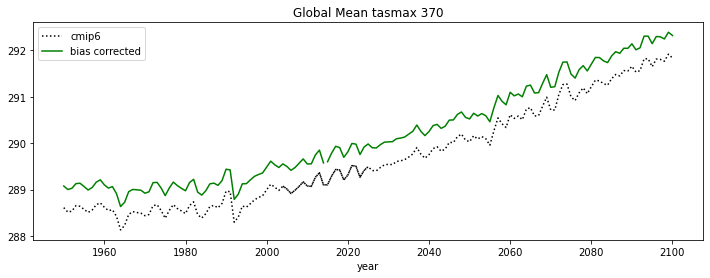

In [14]:
gmst_pdf = plot_gmst_diagnostic(ds_hist_cmip6, 
                                ds_future_cmip6, 
                                ds_hist_bc, 
                                ds_future_bc, 
                                pdf_location, 
                                variable='tasmax', ssp='370', ds_hist_downscaled=None, ds_fut_downscaled=None)

Basic validation of zarr stores (general and variable-specific) 

In [37]:
test_dataset_allvars(ds_future_bc, 'tasmax', 'bias_corrected', time_period="future")

In [38]:
test_dataset_allvars(ds_future_cmip6, 'tasmax', 'cmip6', time_period="future")

In [42]:
test_dataset_allvars(ds_hist_cmip6, 'tasmax', 'cmip6', time_period="hist")

In [44]:
test_temp_range(ds_hist_cmip6, 'tasmax')

create difference plots bw bias corrected and downscaled as well as historical/future bias corrected and downscaled

In [56]:
store_hist_bc = fs_az.get_mapper(data_dict['fine']['bias_corrected']['historical'], check=False)
ds_hist_bc = xr.open_zarr(store_hist_bc)
store_hist_ds = fs_az.get_mapper(data_dict['fine']['downscaled']['historical'], check=False)
ds_hist_ds = xr.open_zarr(store_hist_ds)

store_fut_bc = fs_az.get_mapper(data_dict['fine']['bias_corrected']['ssp370'], check=False)
ds_fut_bc = xr.open_zarr(store_fut_bc)
store_fut_ds = fs_az.get_mapper(data_dict['fine']['downscaled']['ssp370'], check=False)
ds_fut_ds = xr.open_zarr(store_fut_ds)

In [59]:
time_period = '2080_2100'
da_hist_bc = ds_hist_bc[variable].sel(time=slice(years['hist']['start_yr'], years['hist']['end_yr'])).mean('time').load()
da_hist_ds = ds_hist_ds[variable].sel(time=slice(years['hist']['start_yr'], years['hist']['end_yr'])).mean('time').load()

da_future_bc = ds_fut_bc[variable].sel(time=slice(years[time_period]['start_yr'], years[time_period]['end_yr'])).mean('time').load()
da_future_ds = ds_fut_ds[variable].sel(time=slice(years[time_period]['start_yr'], years[time_period]['end_yr'])).mean('time').load()

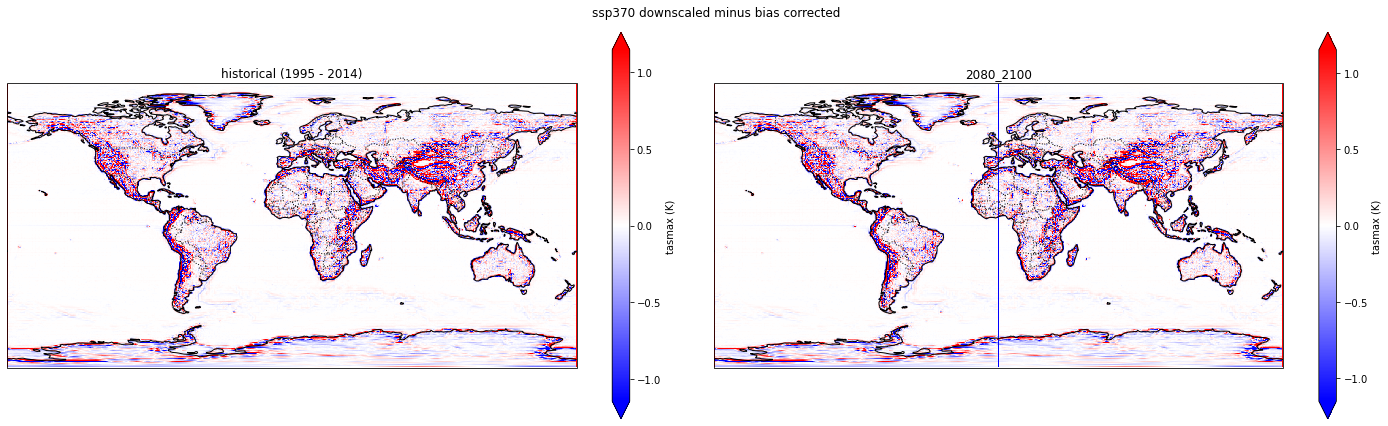

In [114]:
pdf_fname = plot_bias_correction_downscale_differences(da_hist_bc, da_hist_ds, da_future_bc, 
                                           da_future_ds, 'downscaled_minus_biascorrected', 'downscaled', pdf_location,'tasmax',
                                               ssp='ssp370', time_period='2080_2100')

merge validation pdfs created so far 

In [47]:
# ! pip install PyPDF2

In [53]:
# ! ls -lh /home/jovyan/*.pdf

In [52]:
pdf_list = ['/home/jovyan/global_mean_tasmax_370.pdf', 
            '/home/jovyan/tasmax_max_bias_corrected.pdf', 
            '/home/jovyan/tasmax_max_cmip6.pdf', 
            '/home/jovyan/tasmax_max_downscaled.pdf', 
            '/home/jovyan/tasmax_mean_bias_corrected.pdf',
            '/home/jovyan/tasmax_mean_cmip6.pdf',
            '/home/jovyan/tasmax_mean_downscaled.pdf']

In [54]:
merge_validation_pdfs(pdf_list, '/home/jovyan/test_validation.pdf')

Days over 95 degrees F/extreme precip metrics will be added later. 